In [1]:
import os
import numpy as np
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare

%matplotlib notebook

# Automating the proess of finding the filename
dataFolder = 'data'
state = 'TX'
policeDept = 'statewide' # 'statewide' means state patrol
csvFilepath = glob.glob(os.path.join(dataFolder, state, '{}_{}*.csv'.format(state.lower(), policeDept)))[0]
csvFilepath

# Choose column names to load
colNamesList = ['raw_row_number', 
                'date', 
                'time', 
                'county_name', 
                'subject_race', 
                'violation', 
                'citation_issued',
                'warning_issued']

In [2]:
# Automating the creation of rowName:dtype dict
# This throws up a lot of stupid warnings/errors right now!
# df = pd.read_csv(csvFilepath, nrows=5, names=colNamesList)
# dtypeDict = df.dtypes.to_dict()
# dtypeDict

dtypeDict = {'raw_row_number': 'int64', 
             'date': 'object',
             'time': 'object',
             'location': 'object',
             'lat': 'float64',
             'lng': 'float64',
             'county_name': 'object',
             'district': 'object',
             'precinct': 'object',
             'region': 'float64',
             'subject_race': 'object',
             'subject_sex': 'object',
             'officer_id_hash': 'object',
             'type': 'object',
             'violation': 'object',
             'citation_issued': 'bool',
             'warning_issued': 'bool',
             'outcome': 'object',
             'contraband_found': 'object',
             'contraband_drugs': 'object',
             'contraband_weapons': 'object',
             'search_conducted': 'object',
             'search_vehicle': 'object',
             'search_basis': 'object',
             'vehicle_color': 'object',
             'vehicle_make': 'object',
             'vehicle_model': 'object',
             'vehicle_type': 'object',
             'vehicle_year': 'float64',
             'raw_HA_RACE_SEX': 'object',
             'raw_HA_SEARCH_PC_boolean': 'object',
             'raw_HA_SEARCH_CONCENT_boolean': 'object',
             'raw_HA_INCIDTO_ARREST_boolean': 'object',
             'raw_HA_VEHICLE_INVENT_boolean': 'object'}


        
# search_vehicle only has False and nan
# type is just vehicular
# violation column is of interest - reason for stop (split by |?)

In [3]:
chunk = pd.read_csv(csvFilepath,chunksize=1000000, dtype=dtypeDict, usecols=colNamesList)
df = pd.concat(chunk)

In [4]:
df.head()

,raw_row_number,date,time,county_name,subject_race,violation,citation_issued,warning_issued
0,1,2006-01-01,00:00:00,Walker County,white,Drive On Improved Shoulder When Prohibited,False,True
1,2,2006-01-01,00:00:00,Hansford County,white,Speeding-10% or More Above Posted Speed (#),True,False
2,3,2006-01-01,00:00:00,Montgomery County,hispanic,Open Container in Motor Vehicle - Passenger (#),True,False
3,4,2006-01-01,00:00:00,Chambers County,white,Speeding Over Limit (#),False,True
4,5,2006-01-01,00:00:00,Montgomery County,white,No/Improper License Plate Lamp|Driving Under t...,True,True


In [5]:
# for violation in df['violation'].unique():
#     print(violation)

In [6]:
# df.dtypes

In [7]:
# Get unique race values
print(df['subject_race'].unique().tolist())

# We need to discard 'unknown' and 'nan'

['white', 'hispanic', 'black', 'asian/pacific islander', 'unknown', 'other', nan]


In [8]:
# Delete rows with 'unknown' and 'nan' for 'subject_race'
df = df[df['subject_race'] != 'unknown']
df = df[df['subject_race'].notna()]

In [9]:
# Create an empty count dataframe with row and column names
count_df = pd.DataFrame(columns=['Race',
                                 'Total',
                                 'Warning=0_Citation=0',
                                 'Warning=0_Citation=1',
                                 'Warning=1_Citation=0',
                                 'Warning=1_Citation=1'])
count_df['Race'] = df['subject_race'].unique().tolist()
count_df

,Race,Total,Warning=0_Citation=0,Warning=0_Citation=1,Warning=1_Citation=0,Warning=1_Citation=1
0,white,NaN,NaN,NaN,NaN,NaN
1,hispanic,NaN,NaN,NaN,NaN,NaN
2,black,NaN,NaN,NaN,NaN,NaN
3,asian/pacific islander,NaN,NaN,NaN,NaN,NaN
4,other,NaN,NaN,NaN,NaN,NaN


In [10]:
# Iterate over all races, make counts and populate count_df
for race in df['subject_race'].unique().tolist():
    race_df = df[df['subject_race'] == race]
    count_df.loc[count_df['Race'] == race, 'Total'] = len(race_df)
    count_df.loc[count_df['Race'] == race, 'Warning=0_Citation=0'] = len(race_df.query('warning_issued==False & citation_issued==False'))
    count_df.loc[count_df['Race'] == race, 'Warning=0_Citation=1'] = len(race_df.query('warning_issued==False & citation_issued==True'))
    count_df.loc[count_df['Race'] == race, 'Warning=1_Citation=0'] = len(race_df.query('warning_issued==True & citation_issued==False'))
    count_df.loc[count_df['Race'] == race, 'Warning=1_Citation=1'] = len(race_df.query('warning_issued==True & citation_issued==True'))

count_df

,Race,Total,Warning=0_Citation=0,Warning=0_Citation=1,Warning=1_Citation=0,Warning=1_Citation=1
0,white,15418027,1021,3473755,10133830,1809421
1,hispanic,8236546,999,1917773,4790166,1527608
2,black,2723187,148,657798,1607268,457973
3,asian/pacific islander,413119,29,127297,243679,42114
4,other,38092,3,9500,23925,4664


# Plot 1a: Out of all people of a certain race stopped, what is the percentage of people in the following 4 catgories?

## Warning: 0 Citation: 0
## Warning: 1 Citation: 0
## Warning: 0 Citation: 1
## Warning: 1 Citation: 1

In [11]:
# Get info on how the races split up in 4 categories by percentage
percentage_dict = {}

for race in ['white', 'black', 'hispanic']:
    percentage_dict[race] = []
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] / count_df[count_df['Race'] == race]['Total'].values[0])
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0] / count_df[count_df['Race'] == race]['Total'].values[0])
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] / count_df[count_df['Race'] == race]['Total'].values[0])
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0] / count_df[count_df['Race'] == race]['Total'].values[0])

In [12]:
def autolabel(rects, ax, format_str):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(format_str.format(height/100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

<IPython.core.display.Javascript object>


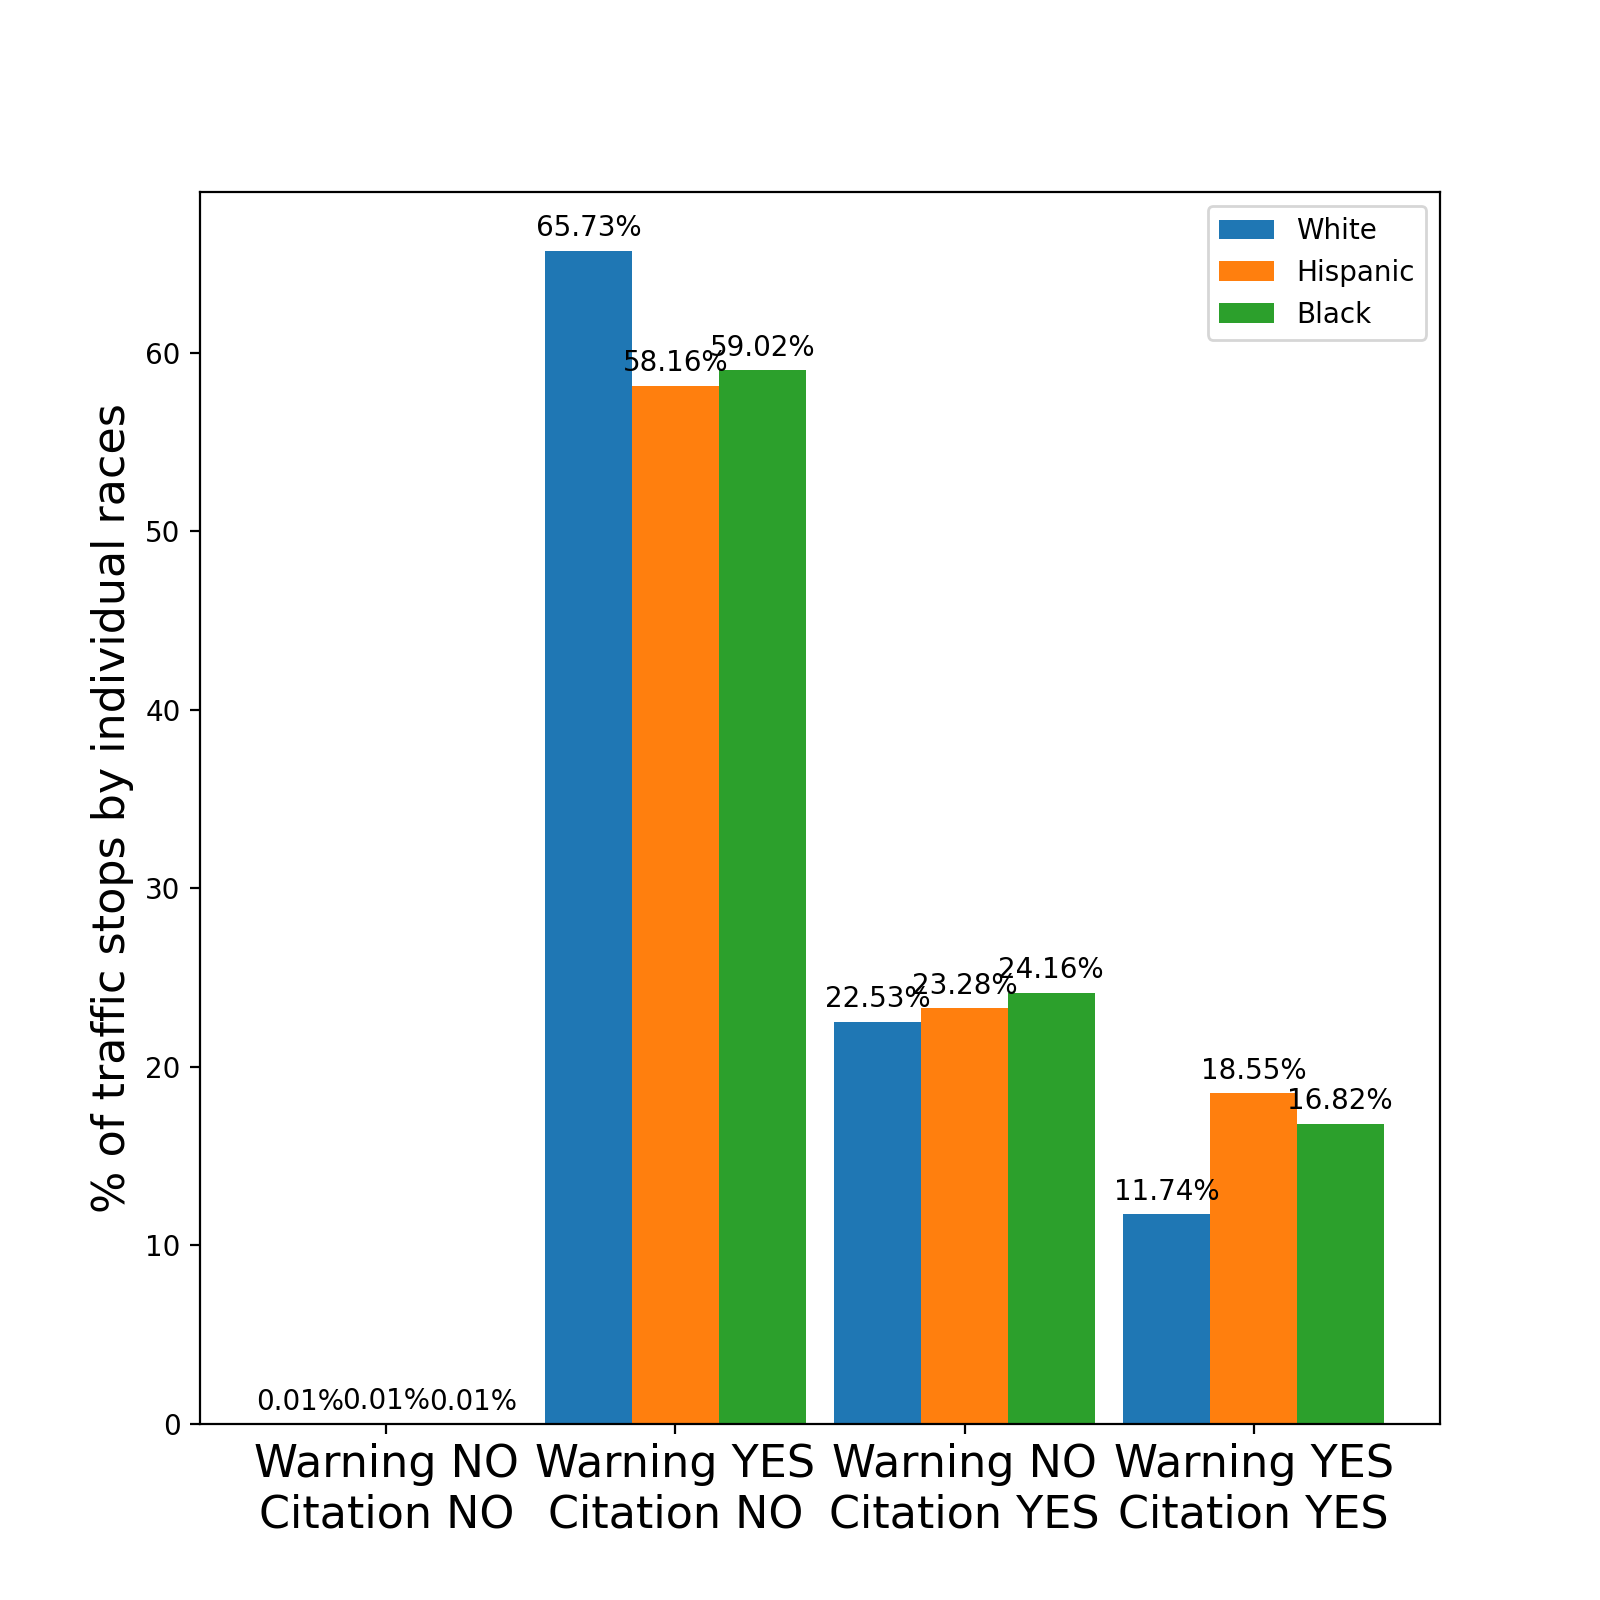

In [13]:
labels = ['Warning NO\nCitation NO', 'Warning YES\nCitation NO', 'Warning NO\nCitation YES', 'Warning YES\nCitation YES']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
rects1 = ax.bar(x - width, percentage_dict['white'], width, label='White')
rects2 = ax.bar(x, percentage_dict['hispanic'], width, label='Hispanic')
rects3 = ax.bar(x + width, percentage_dict['black'], width, label='Black')

ax.set_ylabel('% of traffic stops by individual races', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend()

format_str = '{:.2%}'
autolabel(rects1, ax, format_str)
autolabel(rects2, ax, format_str)
autolabel(rects3, ax, format_str)

plt.show()

# Plot 1b: Out of all people of a certain race stopped, what is the percentage of people that get a citation?

In [14]:
# Get info on how the races split up into citation YES or citation NO by percentage
percentage_dict = {}

for race in ['white', 'black', 'hispanic']:
    percentage_dict[race] = []
    percentage_dict[race].append(100 * (count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] + count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0]) / count_df[count_df['Race'] == race]['Total'].values[0])
    percentage_dict[race].append(100 * (count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] + count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0]) / count_df[count_df['Race'] == race]['Total'].values[0])

<IPython.core.display.Javascript object>


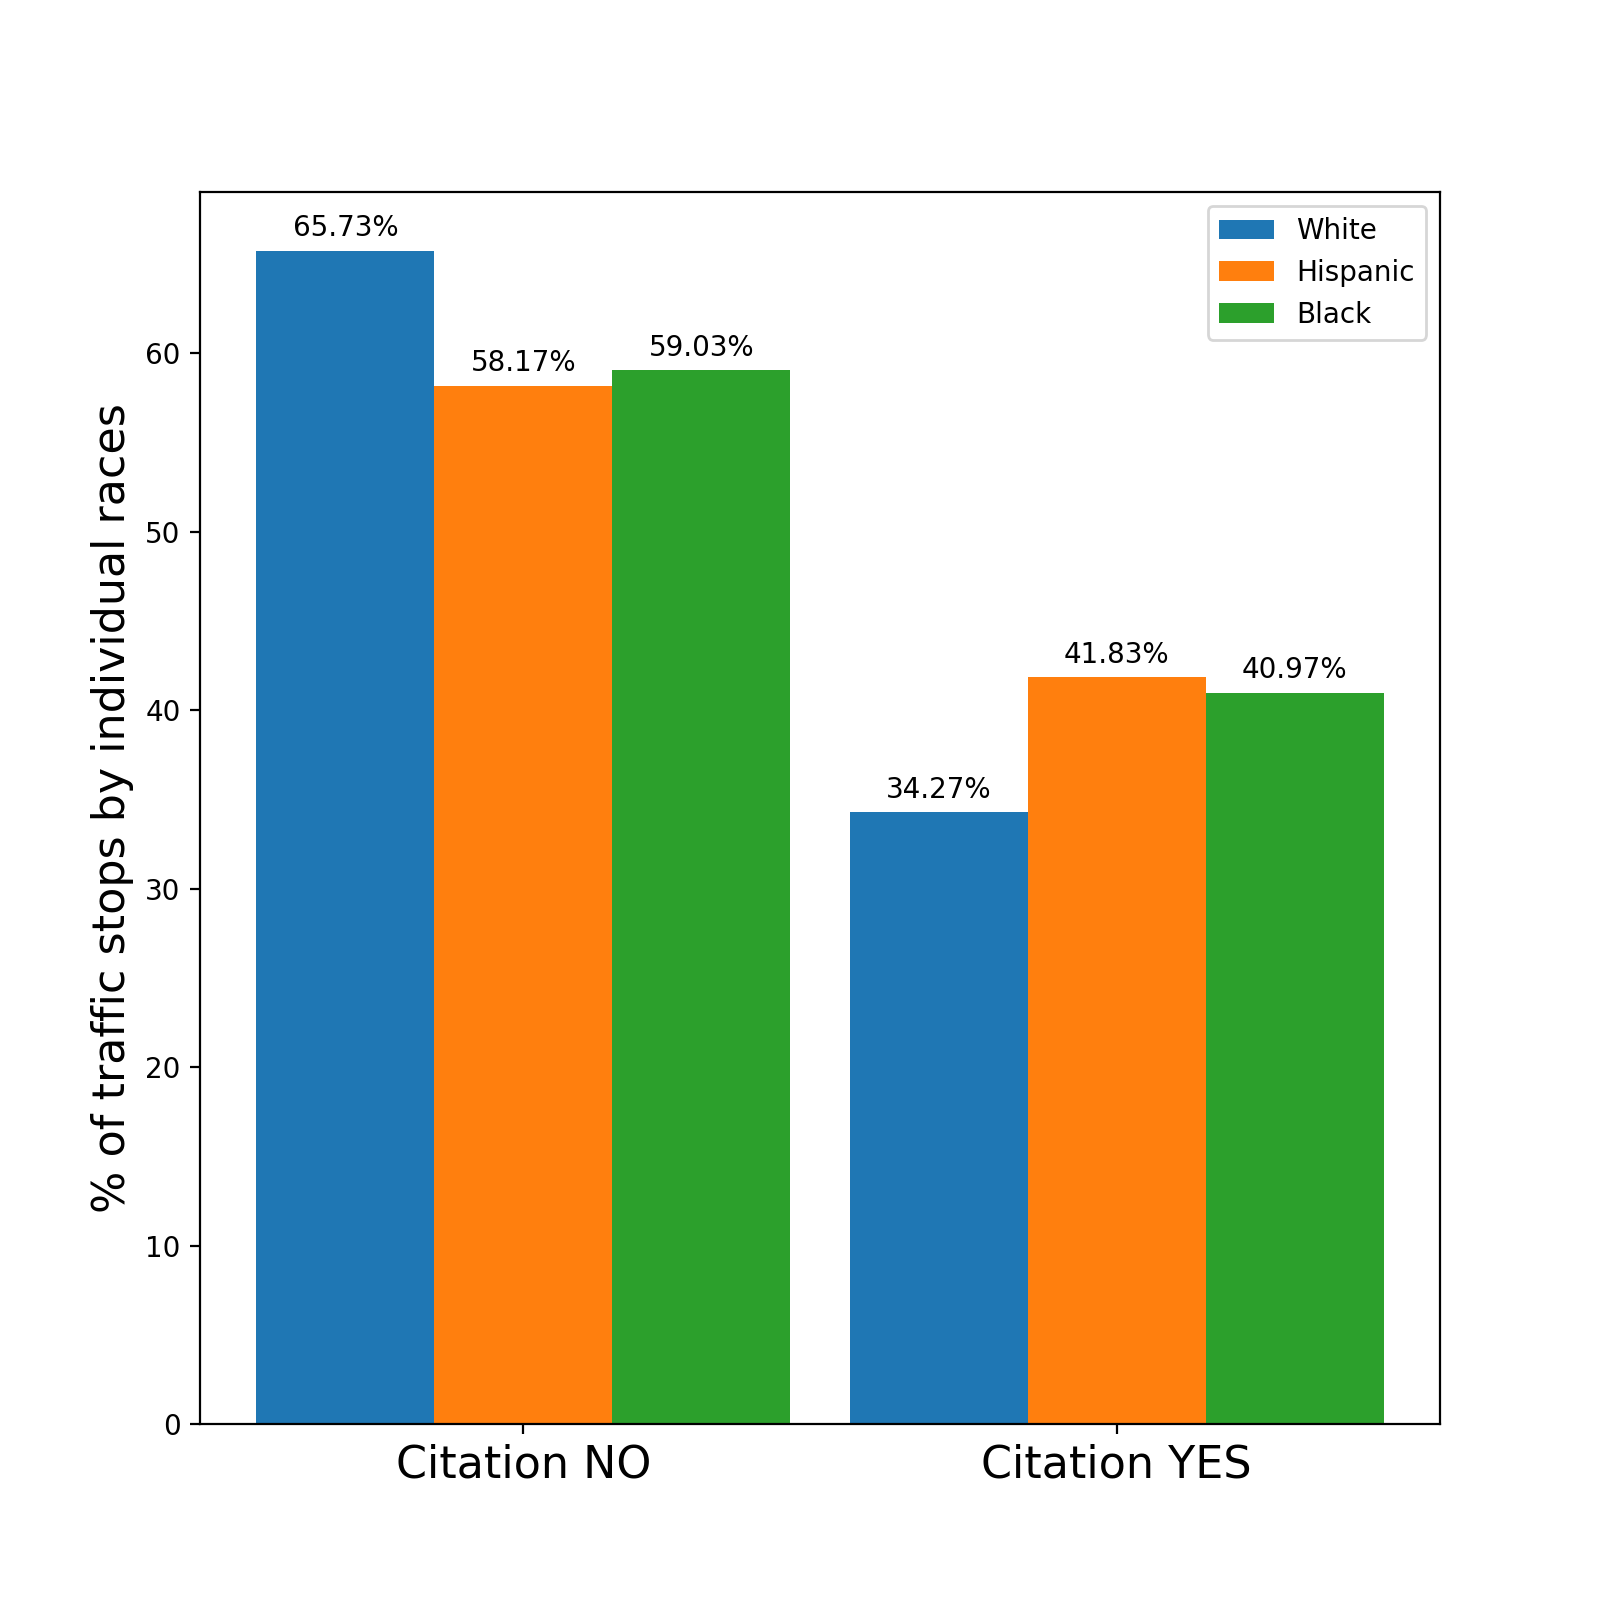

In [15]:
labels = ['Citation NO', 'Citation YES']

x = np.arange(len(labels))  # the label locations

fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111)
rects4 = ax2.bar(x - width, percentage_dict['white'], width, label='White')
rects5 = ax2.bar(x, percentage_dict['hispanic'], width, label='Hispanic')
rects6 = ax2.bar(x + width, percentage_dict['black'], width, label='Black')

ax2.set_ylabel('% of traffic stops by individual races', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=16)
ax2.legend()

format_str = '{:.2%}'
autolabel(rects4, ax2, format_str)
autolabel(rects5, ax2, format_str)
autolabel(rects6, ax2, format_str)

plt.show()

# Plot 2a: What is the percentage of the races in each of the 4 categories?

In [16]:
# Get info on how the races split up in 4 categories by percentage
percentage_dict_2a = {}

for race in ['white', 'black', 'hispanic']:
    percentage_dict_2a[race] = []
    percentage_dict_2a[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] / count_df['Warning=0_Citation=0'].sum())
    percentage_dict_2a[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0] / count_df['Warning=1_Citation=0'].sum())
    percentage_dict_2a[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] / count_df['Warning=0_Citation=1'].sum())
    percentage_dict_2a[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0] / count_df['Warning=1_Citation=1'].sum())

<IPython.core.display.Javascript object>


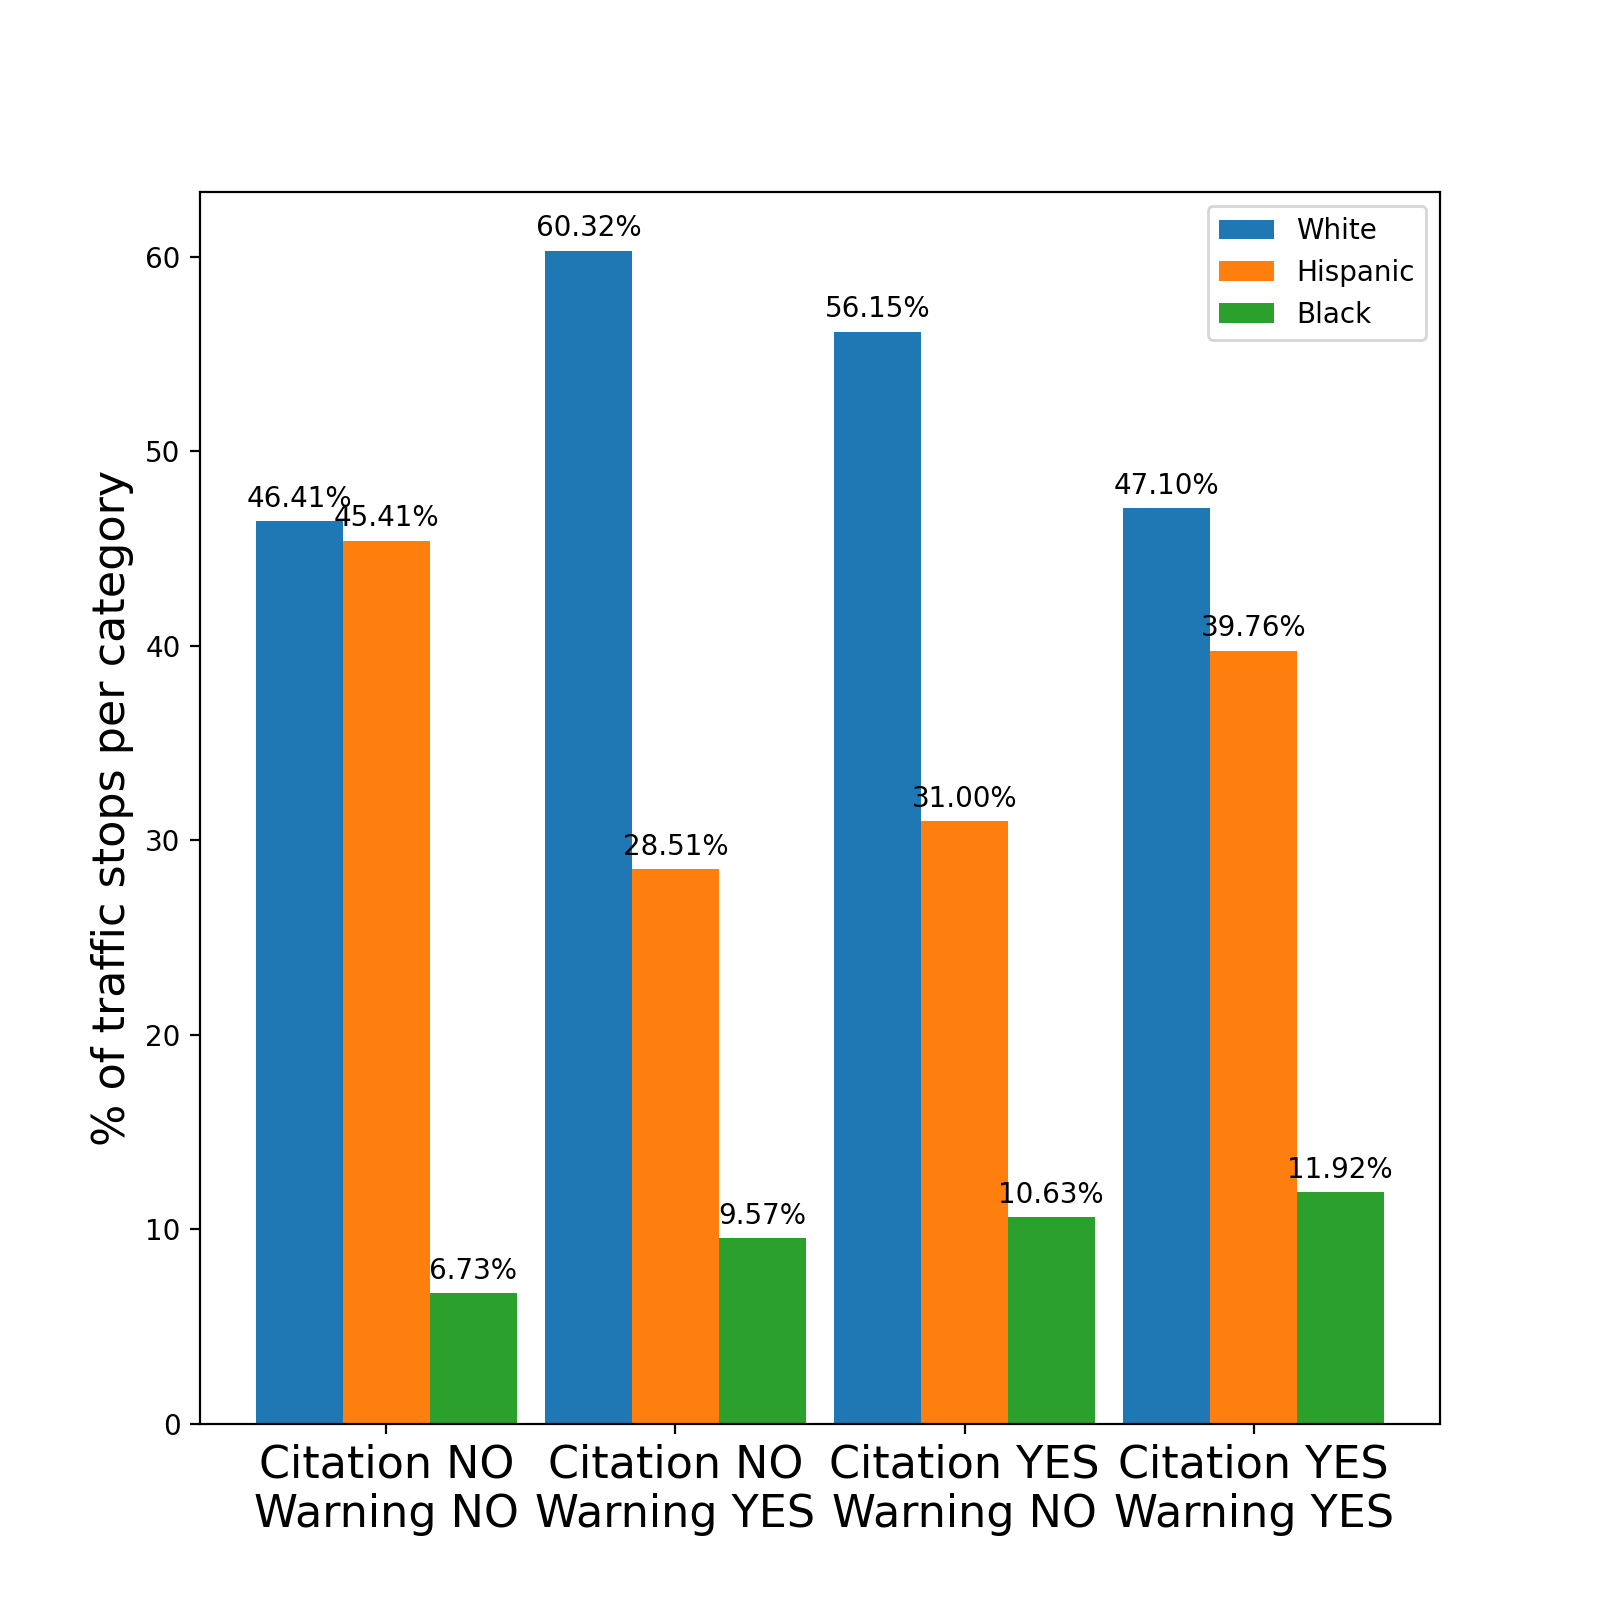

In [17]:
labels = ['Citation NO\nWarning NO', 'Citation NO\nWarning YES', 'Citation YES\nWarning NO', 'Citation YES\nWarning YES']

x = np.arange(len(labels))  # the label locations

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
rects7 = ax1.bar(x - width, percentage_dict_2a['white'], width, label='White')
rects8 = ax1.bar(x, percentage_dict_2a['hispanic'], width, label='Hispanic')
rects9 = ax1.bar(x + width, percentage_dict_2a['black'], width, label='Black')

ax1.set_ylabel('% of traffic stops per category', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=16)
ax1.legend()

format_str = '{:.2%}'
autolabel(rects7, ax1, format_str)
autolabel(rects8, ax1, format_str)
autolabel(rects9, ax1, format_str)

plt.show()

# Plot 2b: Percentage of the races in each category by white and POC only

In [18]:
# Get info on how the races split up in 4 categories by percentage
percentage_dict = {}

for race in ['white', 'poc']:
    percentage_dict[race] = []
    
    if race == 'poc':
        percentage_dict[race].append(100 * (1 - count_df[count_df['Race'] == 'white']['Warning=0_Citation=0'].values[0] / count_df['Warning=0_Citation=0'].sum()))
        percentage_dict[race].append(100 * (1 - count_df[count_df['Race'] == 'white']['Warning=1_Citation=0'].values[0] / count_df['Warning=1_Citation=0'].sum()))
        percentage_dict[race].append(100 * (1 - count_df[count_df['Race'] == 'white']['Warning=0_Citation=1'].values[0] / count_df['Warning=0_Citation=1'].sum()))
        percentage_dict[race].append(100 * (1 - count_df[count_df['Race'] == 'white']['Warning=1_Citation=1'].values[0] / count_df['Warning=1_Citation=1'].sum()))
    else:
        percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] / count_df['Warning=0_Citation=0'].sum())
        percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0] / count_df['Warning=1_Citation=0'].sum())
        percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] / count_df['Warning=0_Citation=1'].sum())
        percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0] / count_df['Warning=1_Citation=1'].sum())

<IPython.core.display.Javascript object>


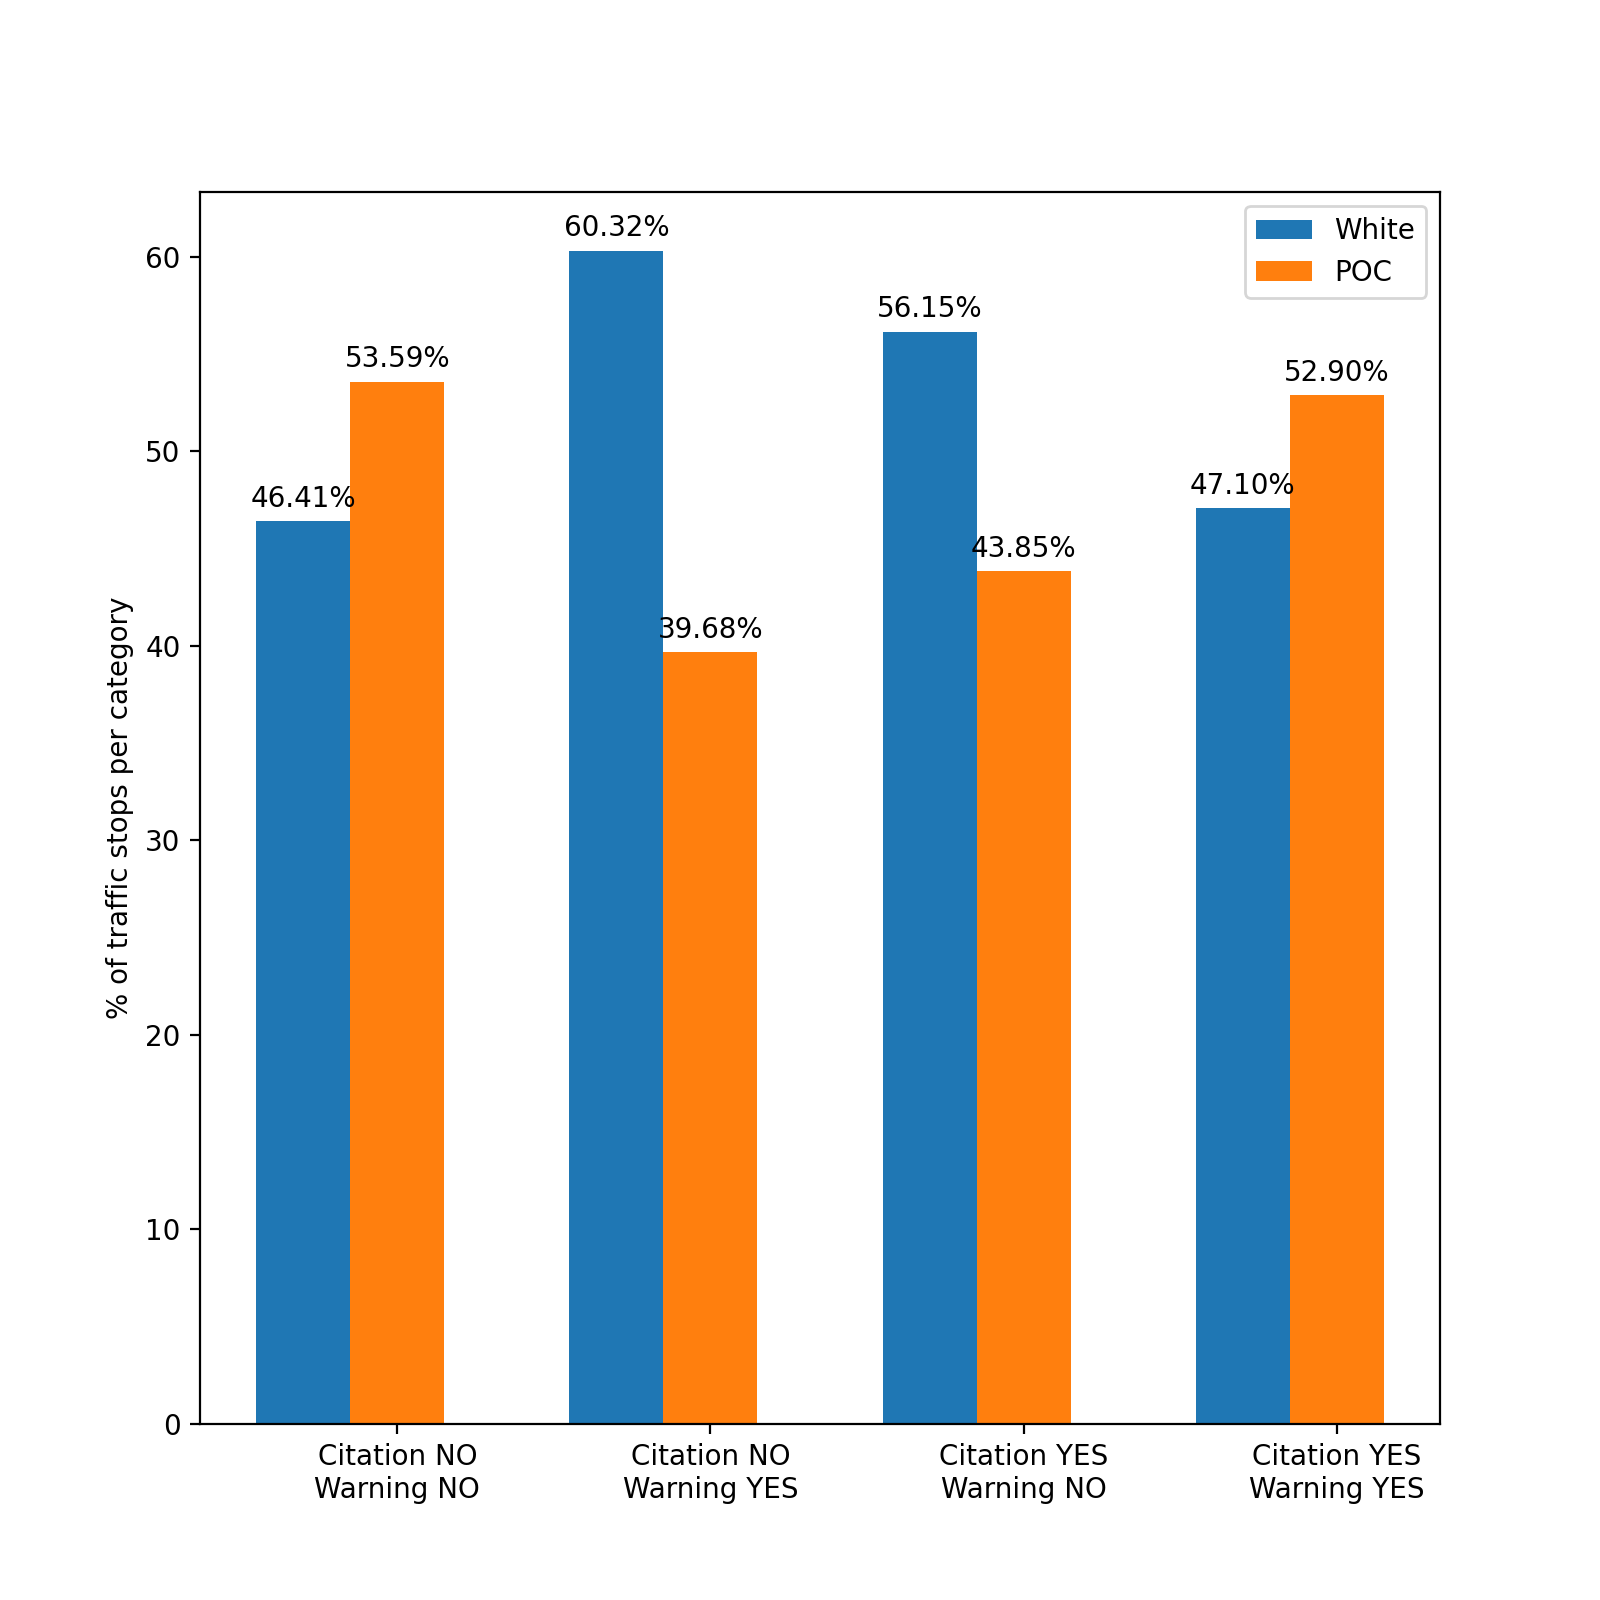

In [19]:
fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(111)
rects0 = ax3.bar(x - width, percentage_dict['white'], width, label='White')
rects11 = ax3.bar(x, percentage_dict['poc'], width, label='POC')

ax3.set_ylabel('% of traffic stops per category')
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.legend()

format_str = '{:.2%}'
autolabel(rects0, ax3, format_str)
autolabel(rects11, ax3, format_str)

plt.show()

# Plot 2c: Percentage of the races in citation/warning/nothing

In [20]:
percentage_dict = {}

for race in ['white', 'black', 'hispanic']:
    percentage_dict[race] = []
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] / count_df['Warning=0_Citation=0'].sum())
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] / count_df['Warning=0_Citation=1'].sum())
    percentage_dict[race].append(100 * (count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0] + count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0]) / (count_df['Warning=1_Citation=0'].sum() + count_df['Warning=1_Citation=1'].sum()))

<IPython.core.display.Javascript object>


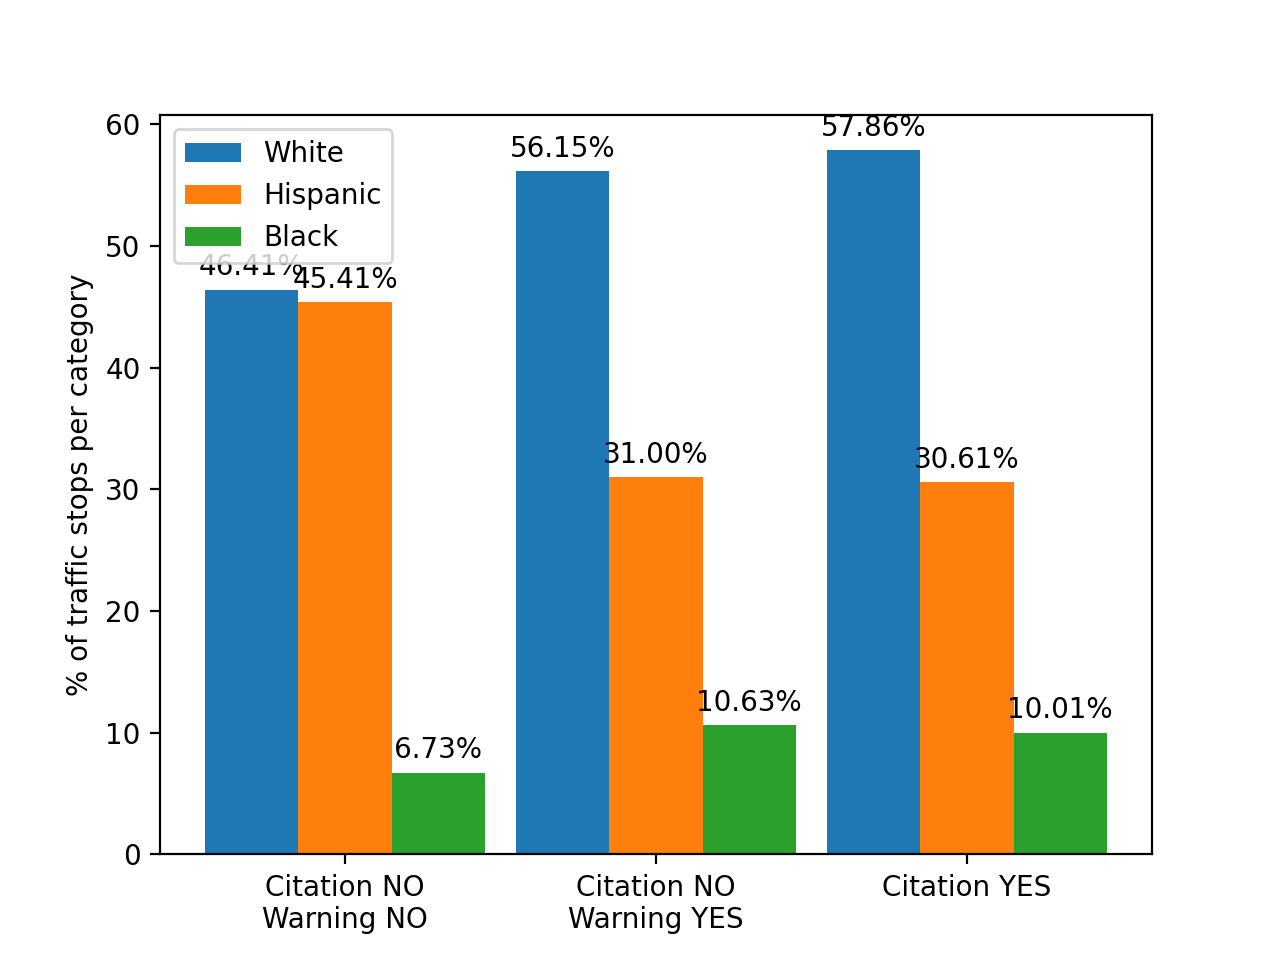

In [21]:
labels = ['Citation NO\nWarning NO', 'Citation NO\nWarning YES', 'Citation YES']

x = np.arange(len(labels))  # the label locations

fig4, ax4 = plt.subplots()
rects12 = ax4.bar(x - width, percentage_dict['white'], width, label='White')
rects13 = ax4.bar(x, percentage_dict['hispanic'], width, label='Hispanic')
rects14 = ax4.bar(x + width, percentage_dict['black'], width, label='Black')

ax4.set_ylabel('% of traffic stops per category')
ax4.set_xticks(x)
ax4.set_xticklabels(labels)
ax4.legend()

format_str = '{:.2%}'
autolabel(rects12, ax4, format_str)
autolabel(rects13, ax4, format_str)
autolabel(rects14, ax4, format_str)

plt.show()

# Chi Square Test on Plot 2a

In [22]:
f_exp = [[78.7, 39.7, 12.9]]*4 # from 2019 https://www.census.gov/quickfacts/TX 
f_obs = []

for race in ['white', 'hispanic', 'black']:
    f_obs.append(percentage_dict_2a[race]) # Citation NO\nWarning NO, Citation NO\nWarning YES, Citation YES\nWarning NO, Citation YES\nWarning YES

f_obs = np.array(f_obs)
f_exp = np.array(f_exp).T

f_obs

array([[46.40909091, 60.32448139, 56.15399177, 47.09850642],
       [45.40909091, 28.51481421, 31.00121029, 39.76302651],
       [ 6.72727273,  9.56771611, 10.63344521, 11.9208544 ]])

In [23]:
chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=array([17.02377017,  8.30259492,  8.76324641, 12.76380233]), pvalue=array([0.00020106, 0.01574398, 0.01250504, 0.0016919 ]))

# Chi Square Test on No Citation/Citation

In [24]:
f_exp = [[78.7, 39.7, 12.9]]*2
f_obs = []
races = ['white', 'black', 'hispanic']
for i in range(len(races)):
    f_obs.append([])
    f_obs[i].append(100 * (count_df[count_df['Race'] == races[i]]['Warning=0_Citation=0'].values[0] + count_df[count_df['Race'] == races[i]]['Warning=1_Citation=0'].values[0]) / (count_df['Warning=0_Citation=0'].sum() + count_df['Warning=1_Citation=0'].sum()))
    f_obs[i].append(100 * (count_df[count_df['Race'] == races[i]]['Warning=0_Citation=1'].values[0] + count_df[count_df['Race'] == races[i]]['Warning=1_Citation=1'].values[0]) / (count_df['Warning=0_Citation=1'].sum() + count_df['Warning=1_Citation=1'].sum()))
    
f_exp = np.array(f_exp).T
f_obs = np.array(f_obs)

In [25]:
chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=array([46.06859184, 64.85805908]), pvalue=array([9.91590568e-11, 8.24615353e-15]))